In [1]:
import numpy as np

In [2]:
def function_S(input):
    # input should be array
    # output array
    flattened_input = input.flatten()
    output = [[0,           -flattened_input[2],    flattened_input[1]],
              [flattened_input[2],  0,              -flattened_input[0]],
              [-flattened_input[1], flattened_input[0],     0]]
    return np.array(output)

In [3]:
def rodrigues_formula(quaternion):
    '''
    quaternion -> R_tile_bar
    input: [w,x,y,z]
    output R_tile_bar (rotation matrix)
    '''
    return np.eye(3) + 2*np.matmul(function_S(quaternion[1:]), (quaternion[0]*np.eye(3) + function_S(quaternion[1:])))


In [4]:
l = 3
k = 1
q = [10, 10, 10]
Q = np.diag(np.hstack([np.diag(q[0]*np.eye(3)), np.diag(q[1]*np.eye(3)), np.diag(q[2]*np.eye(3))]))
V = np.diag(np.hstack([np.diag(0.1*np.eye(3)), np.diag(np.eye(3))]))
P_0 = np.diag(np.hstack([np.diag(np.eye(3)), np.diag(100*np.eye(3))]))
#initial state
p_0 = np.array([[2.5, 0, 10]]).T
R_0 = np.eye(3)

#initial estimation
p_hat_0 = np.array([[-2, 4, 3]]).T
Lambda_bar_0 = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z
## R_hat = R x R_tile_bar
R_hat_0 = np.matmul(R_0, rodrigues_formula(Lambda_bar_0))

# landmarks
z = np.array([[[0, 0, 0]], 
              [[5, 0, 0]],
              [[2.5, 2.5, 0]]])

In [5]:
R_0

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [6]:
def function_A(omega):
    A11 = -function_S(omega)
    A12 = np.zeros((3,3))
    A21 = np.zeros((3,3))
    A22 = -function_S(omega)
    return np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))

In [7]:
def function_Pi(input):
    '''
    Pi_x := I_3 - xx^T
    input: array
    output P_x
    '''
    return np.eye(3) - np.matmul(input, np.transpose(input))

In [8]:
def function_d(input_rot, input_p, input_z):
    '''
    calculate d_i(t) := R^T(t)(p(t) - z_i)/|p(t)-z_i|
    '''
    norm = (input_p - input_z)/np.linalg.norm(input_p - input_z)
    return np.matmul(np.transpose(input_rot), norm)

In [9]:
def function_C(input_R, input_R_hat, input_p, input_z):
    for landmark_idx in range(l):
        # S(R_hat.T x z)
        #TODO: remember to change the R_0 and p_0 below for gerenal
        first = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx])))
        second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        final = -np.matmul(first, second)
        C_landmark = np.hstack((final, first))
        if landmark_idx == 0:
            output_C = C_landmark
        else:
            output_C = np.vstack((output_C, C_landmark))
    return output_C

In [10]:
def add_bar(input_rot, input_p):
    return np.matmul(np.transpose(input_rot), input_p)

In [11]:
# observer equation
def observer_equation(input_omega, input_R, input_R_hat, input_p, input_p_hat, input_z, input_v, input_A, input_C, input_P, input_Q, input_V):
    # omega_hat , p_bar_hat_dot
    # omega
    first_upper = input_omega
    #TODO: change this for general (R_0)
    
    input_p_bar_hat = add_bar(input_R, input_p_hat)
    # -S(omega)p_bat_hat + v_bar
    #TODO: change this for general (R_0)
    first_lower = np.matmul(-function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
    first_part = np.vstack((first_upper, first_lower))

    # omega_hat second part upper
    final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*S(R_hat.T x z)
        first = q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        #Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        second = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final += np.matmul(first, np.matmul(second, third))

    # omega_hat second part lower
    final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        first = q[landmark_idx]*function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final2 += np.matmul(first, second)
    second_part = np.vstack((final, final2))
    #kP[]
    #full second part 
    second_part = k*np.matmul(input_P, second_part)

    # Final
    output_omega_hat_p_bar_hat_dot = first_part - second_part

    output_omega = output_omega_hat_p_bar_hat_dot[0:3]
    output_R_hat_dot = np.matmul(input_R_hat, function_S(output_omega))

    output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    return output_omega_hat_p_bar_hat_dot, output_R_hat_dot, output_P_dot

In [12]:
def function_K(input_P, input_C, input_Q, input_k):
    #TODO: HAVENT CHECK THIS FUNCTION
    return input_k* np.matmul(input_P, np.matmul(np.transpose(input_C), input_Q))

In [13]:
# time = np.linspace(0, 10, 9)
# R_hat_dot = None
# p_bar_hat_dot = None
# P_dot = None
# omega_hat = None
# R_tile_bar = None
# for idx, t in enumerate(time):

#     ######################################################
#     ############### expected trajectory ##################
#     ######################################################
#     #current pose
#     p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))
#     #current velocity
#     v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0.6*t]]))
#     #current angular velocity
#     omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    
#     if idx == 0:
#         R = R_0
#         R_hat = R_hat_0 # can also be = np.matmul(R_0, rodrigues_formula(Lambda_bar_0))
#         p_hat = p_hat_0
#         P = P_0
#         p_bar_hat = add_bar(R, p_hat)
#     else:
#         R = 
#         P = P_dot
#         v_bar = add_bar(R, v)
#         # system predict
#         #TODO: use this R_hat_dot to calculate _2_lambda_bar??
#         #TODO: how to get R_tile_bar???
        
#         #omega_tile_bar := omega - R_tile_bar.T x omega_hat
#         omega_tile_bar = omega - np.matmul(R_tile_bar, omega_hat)
#         _2_lambda_bar_dot = -np.matmul(function_S(omega), _2_lambda_bar) + omega_tile
#         # change _2_lambda_bar_dot to R_tile_bar
#         R_tile_bar = rodrigues_formula(_2_lambda_bar_dot/2) ### R_hat = R x R_tile_bar
#         R_hat = np.matmul(R, R_tile_bar) 
#         # p_bar_hat = ?????
#         p_bar_dot = -np.matmul(function_S(omega), p_bar) + v_bar ####TODO: should this be the p_bar_hat???

#     #current A
#     A = function_A(omega)
#     #TODO: R_0, p_0 should be changing
#     #current C
#     C = function_C(R, R_hat, p, z)

#     #observer

#     #Kalman gain
#     K = 1 #in the example
#     # K = function_K(P, C, Q, k)

#     #TODO: R_0, p_0, p_hat_0, P_0 should be changing
#     #current observer equations
#     omega_hat_p_bar_hat_dot, R_hat_dot, P_dot = observer_equation(omega, R, R_hat, p, p_bar_hat, z, v, A, C, P, Q, V)
#     omega_hat = omega_hat_p_bar_hat_dot[0:3]
#     p_bar_hat_dot = omega_hat_p_bar_hat_dot[3:]
#     break


In [14]:
def remove_bar(input_R, input_p):
    return np.matmul(np.transpose(np.linalg.inv(input_R)), input_p)

In [15]:
# #################################
# ###### Euler ######
# #################################

# time = np.linspace(0, 1, 9)
# R_hat_dot = None
# p_bar_hat_dot = None
# P_dot = None
# omega_hat = None
# R_tile_bar = None
# p_hat_dot = None

# for idx, t in enumerate(time):

#     ######################################################
#     ############### expected trajectory ##################
#     ######################################################
#     #current pose
#     p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))

#     ######################################################
#     #################### Meaasurment #####################
#     ######################################################
#     #current velocity
#     v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
#     #current angular velocity
#     omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    
#     ######################################################
#     ################# initialization #####################
#     ######################################################
#     if idx == 0:
#         Rot_hat = R_hat_0 
#         Rot = R_0
#         p_hat = p_hat_0
#         P_ricatti = P_0
#         omega = omega
#     else:
#         if idx != 1:
#             Rot_hat = R_next_hat
#             p_hat = p_next_hat
#             P_ricatti = P_dot
#             omega = omega #omega_hat
#             Rot = np.matmul(Rot, function_S(omega))
#         ######################################################
#         ##################### update #########################
#         ######################################################
#         ### SYSTEM 
#         A_system = function_A(omega)
#         C_obs = function_C(Rot, Rot_hat, p, z)
#         # P_dot in the observer_equation
    
#         ### Observer
#         #Kalman gain
#         K = 1 #in the example
#         # K = function_K(P, C, Q, k)
    
#         #TODO: R_0, p_0, p_hat_0, P_0 should be changing
#         #current observer equations
#         omega_hat_p_bar_hat_dot, R_hat_dot, P_dot = observer_equation(omega,
#                                             Rot, Rot_hat, p, p_hat, z, v, A_system, C_obs, P_ricatti, Q, V)
#         omega_hat = omega_hat_p_bar_hat_dot[0:3]
#         p_bar_hat_dot = omega_hat_p_bar_hat_dot[3:]
#         print("========================")
#         print(omega_hat_p_bar_hat_dot)
#         print("========================")
#         R_next_hat = Rot_hat + R_hat_dot*(t-last_time)
#         p_next_bar_hat = p_hat + p_bar_hat_dot*(t - last_time)
#         p_next_hat = remove_bar(R_next_hat, p_next_bar_hat)

#     last_time = t

In [16]:
import numpy as np
delta_t = 0.01
times = np.arange(0, 1, delta_t)
omega_hat = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
input_R = R_0
input_p_bar_hat = add_bar(R_hat_0, p_hat_0)
input_R_hat = R_hat_0
input_P = P_0
input_p_bar_hat_list = []
for t in times:
    input_z = z
    input_k = k
    input_Q = Q
    input_V = V
    # pose
    input_p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))
    
    # velocity
    input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
    # angular velocity
    input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    
    

    # input_R = np.matmul(input_R, function_S(input_omega))
    
    input_A = function_A(input_omega)
    input_C = function_C(input_R, input_R_hat, input_p, input_z)

    # omega_hat , p_bar_hat_dot
    # omega
    first_upper = input_omega
    
    # -S(omega)p_bat_hat + v_bar
    #TODO: change this for general (R_0)
    first_lower = np.matmul(-function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
    first_part = np.vstack((first_upper, first_lower))

    # omega_hat second part upper
    final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*S(R_hat.T x z)
        first = q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        #Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        second = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final += np.matmul(first, np.matmul(second, third))

    # omega_hat second part lower
    final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        first = q[landmark_idx]*function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final2 += np.matmul(first, second)
    second_part = np.vstack((final, final2))
    #kP[]
    #full second part 
    second_part = input_k*np.matmul(input_P, second_part)

    # Final
    output_omega_hat_p_bar_hat_dot = first_part - second_part

    input_P = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    
    omega_hat += output_omega_hat_p_bar_hat_dot[0:3]*delta_t
    input_R_hat += np.matmul(input_R_hat, function_S(omega_hat))*delta_t
    input_p_bar_hat += output_omega_hat_p_bar_hat_dot[3:]*delta_t
    input_p_bar_hat_list.append(input_p_bar_hat.flatten())
    input_R += np.matmul(input_R, function_S(input_omega))*delta_t

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    # return np.concatenate((output_R.flatten(), output_R_hat_dot.flatten(), p_bar_hat_dot.flatten(), output_P_dot.flatten()))


/tmp/ipykernel_127756/235388623.py:68: RuntimeWarning: overflow encountered in matmul
  input_P = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
/tmp/ipykernel_127756/235388623.py:71: RuntimeWarning: overflow encountered in matmul
  input_R_hat += np.matmul(input_R_hat, function_S(omega_hat))*delta_t
/tmp/ipykernel_127756/3764912973.py:6: RuntimeWarning: invalid value encountered in matmul
  second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
/tmp/ipykernel_127756/235388623.py:43: RuntimeWarning: invalid value encountered in matmul
  first = q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
/tmp/ipykernel_127756/235388623.py:48: RuntimeWarning: invalid value encountered in matmul
  third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose

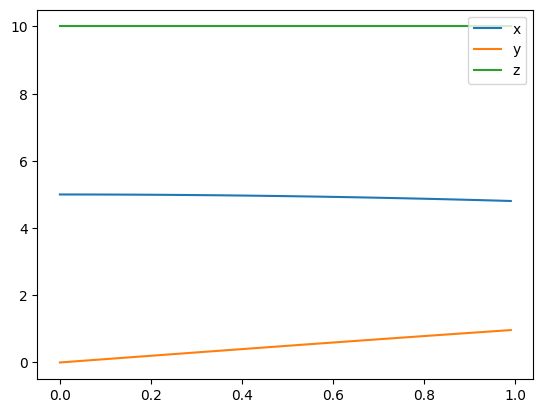

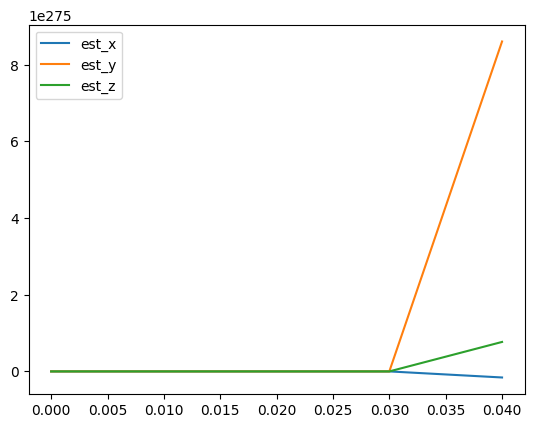

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [17]:
from copy import deepcopy
p_bar_print = []
R_curr = np.eye(3)
for idx, t in enumerate(times):
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    omega = np.array([0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t])
    R_new = np.dot(R_curr, function_S(omega))
    # R_curr = deepcopy(R_new)
    p_bar_temp = np.matmul(np.transpose(R_new), p)
    p_bar_print.append(p)

import matplotlib.pyplot as plt
figure = plt.subplot()
plt.plot(times, p_bar_print, label=["x", "y", "z"])
plt.legend()
plt.show()

plt.plot(times, input_p_bar_hat_list, label=["est_x", "est_y", "est_z"])
plt.legend()
plt.show()

plt.plot(times, p_bar_print-input_p_bar_hat_list, label=["diff_x", "diff_y", "diff_z"])
plt.legend()
plt.show()